<a href="https://colab.research.google.com/github/KansaiUser/BehavioralCloning/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Behavioral Clonning**

This notebook is for Udacity's Behavioral Clonning Project


## Load the Data

Here I load the data provided by Udacity

(as an alternative there is also another set of data)


In [1]:
!git clone https://github.com/KansaiUser/BehavioralCloneData
#!git clone https://github.com/KansaiUser/BehavioralCloningTrackData


Cloning into 'BehavioralCloneData'...
remote: Enumerating objects: 24112, done.
remote: Total 24112 (delta 0), reused 0 (delta 0), pack-reused 24112
Receiving objects: 100% (24112/24112), 305.31 MiB | 38.72 MiB/s, done.
Checking out files: 100% (24109/24109), done.


In [2]:
!ls BehavioralCloneData/
#!ls BehavioralCloningTrackData/

driving_log.csv  IMG


The data is loaded in the current directory of the Google Cloud Machine

## Import the necessary libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

##  Get the Data into a Dataframe ready to be used, and show some statistics 

In [4]:
folder= "BehavioralCloneData"
#folder= "BehavioralCloningTrackData"
data=pd.read_csv(os.path.join(folder,"driving_log.csv"))
data.head()

center  ...      speed
0  IMG/center_2016_12_01_13_30_48_287.jpg  ...  22.148290
1  IMG/center_2016_12_01_13_30_48_404.jpg  ...  21.879630
2  IMG/center_2016_12_01_13_31_12_937.jpg  ...   1.453011
3  IMG/center_2016_12_01_13_31_13_037.jpg  ...   1.438419
4  IMG/center_2016_12_01_13_31_13_177.jpg  ...   1.418236

[5 rows x 7 columns]

In [5]:
num_bins = 25
samples_per_bin = 800
hist, bins = np.histogram(data['steering'], num_bins)

In [6]:
len(data)

8036

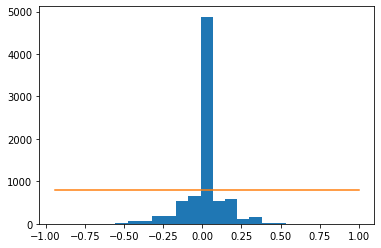

In [7]:
plt.hist(data['steering'],bins)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

As you can see the data is pretty much accumulated in the center, so I limit the number of data per bin

In [8]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

In [9]:
print(len(remove_list))

4080


In [10]:
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 4080
remaining: 3956


(array([  4.,   1.,   2.,   2.,   4.,  18.,  55.,  55., 174., 193., 532.,
        656., 800., 527., 577., 122., 169.,  26.,  25.,   6.,   5.,   1.,
          0.,   0.,   2.]),
 array([-0.9426954 , -0.86498758, -0.78727977, -0.70957195, -0.63186414,
        -0.55415632, -0.4764485 , -0.39874069, -0.32103287, -0.24332506,
        -0.16561724, -0.08790942, -0.01020161,  0.06750621,  0.14521402,
         0.22292184,  0.30062966,  0.37833747,  0.45604529,  0.5337531 ,
         0.61146092,  0.68916874,  0.76687655,  0.84458437,  0.92229218,
         1.        ]),
 <a list of 25 Patch objects>)

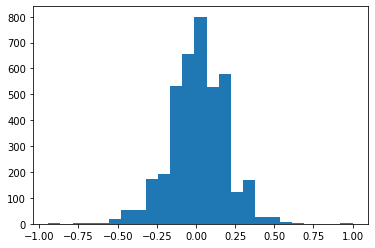

In [11]:
plt.hist(data['steering'],bins)

Seen this data we can see that the data is still pretty much inclined toward the center. I suspect that this will make driving in close turns a bit difficult, and I will need to supplement this later by augmenting the data

## Getting Training and Validation Data

First we get arrays of the images and the steering data

In [12]:
data.iloc[0]

center      IMG/center_2016_12_01_13_31_13_037.jpg
left          IMG/left_2016_12_01_13_31_13_037.jpg
right        IMG/right_2016_12_01_13_31_13_037.jpg
steering                                         0
throttle                                         0
brake                                            0
speed                                      1.43842
Name: 3, dtype: object

In [13]:
def get_image_steering(folder,df):
  image_path_list=[]
  steering_list=[]
  for i in range(len(df)):  #not data
    image_path=df.iloc[i].center.strip()
    image_path_list.append(os.path.join(folder,image_path))
    steering= df.iloc[i].steering
    steering_list.append(steering)

    image_path=df.iloc[i].left.strip()
    image_path_list.append(os.path.join(folder,image_path))
    steering= df.iloc[i].steering+0.25 #0.15  #Try 0.25
    steering_list.append(steering)

    image_path=df.iloc[i].right.strip()
    image_path_list.append(os.path.join(folder,image_path))
    steering= df.iloc[i].steering-0.25  #0.15  #Try -0.25
    steering_list.append(steering)


  image_path_array=np.array(image_path_list)
  steering_array=np.array(steering_list)
  return image_path_array,steering_array


In [14]:
im,st=get_image_steering(folder,data)
print(im)
print(st)

['BehavioralCloneData/IMG/center_2016_12_01_13_31_13_037.jpg'
 'BehavioralCloneData/IMG/left_2016_12_01_13_31_13_037.jpg'
 'BehavioralCloneData/IMG/right_2016_12_01_13_31_13_037.jpg' ...
 'BehavioralCloneData/IMG/center_2016_12_01_13_46_38_922.jpg'
 'BehavioralCloneData/IMG/left_2016_12_01_13_46_38_922.jpg'
 'BehavioralCloneData/IMG/right_2016_12_01_13_46_38_922.jpg']
[ 0.    0.25 -0.25 ...  0.    0.25 -0.25]


In [15]:
type(st[0])

numpy.float64

Now we have to get our Train and validation data

In [16]:
X_train,X_valid,y_train,y_valid=train_test_split(im,st,test_size=0.2,random_state=6)
print('Train size',len(X_train))
print('Validation size',len(X_valid))

Train size 9494
Validation size 2374


Text(0.5, 1.0, 'Validation set')

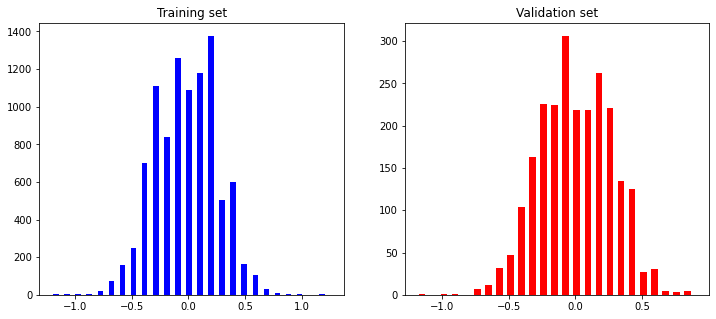

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Image Preprocessing

Let's take any image, for example element 50

In [18]:
def preprocess(image):
  image=image[60:135,:,:]
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
  image = cv2.GaussianBlur(image,  (3, 3), 0)
  image = cv2.resize(image, (200, 66))
  image = image/255
  return image

In [19]:
any_image=im[50]
print(any_image)
original_image=mpimg.imread(any_image)
preprocessed_image=preprocess(original_image)
print(original_image.shape)
print(preprocessed_image.shape)

BehavioralCloneData/IMG/right_2016_12_01_13_32_45_377.jpg
(160, 320, 3)
(66, 200, 3)


Text(0.5, 1.0, 'Preprocessed Image')

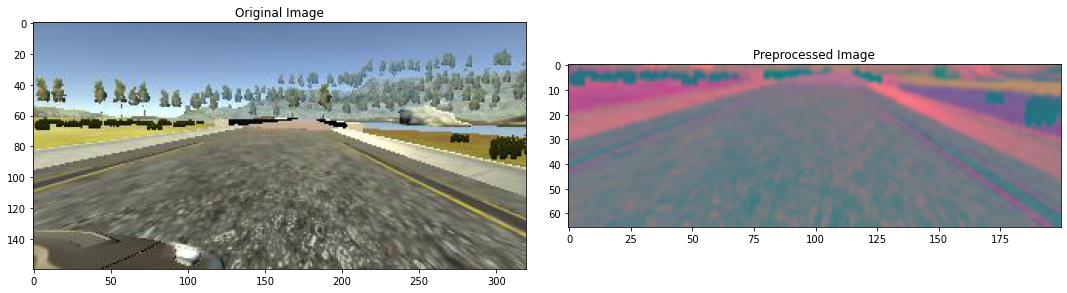

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

## Image Augmentation

I am going to perform a series of operations to augment the data

#### Zoom

In [21]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.5))
  image=zoom.augment_image(image)
  return image

In [22]:
image = im[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

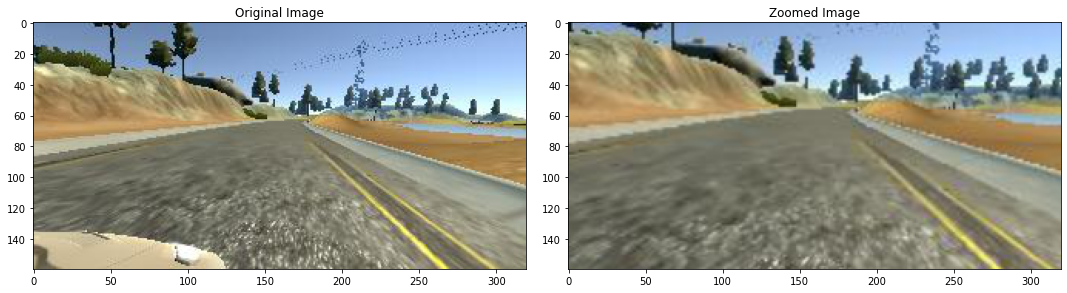

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [24]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [25]:
image = im[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

Text(0.5, 1.0, 'Panned Image')

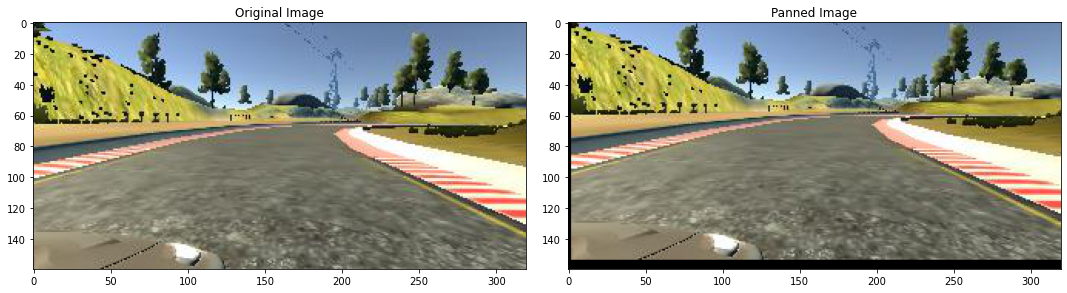

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [27]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [28]:
image = im[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

Text(0.5, 1.0, 'Brightness altered image ')

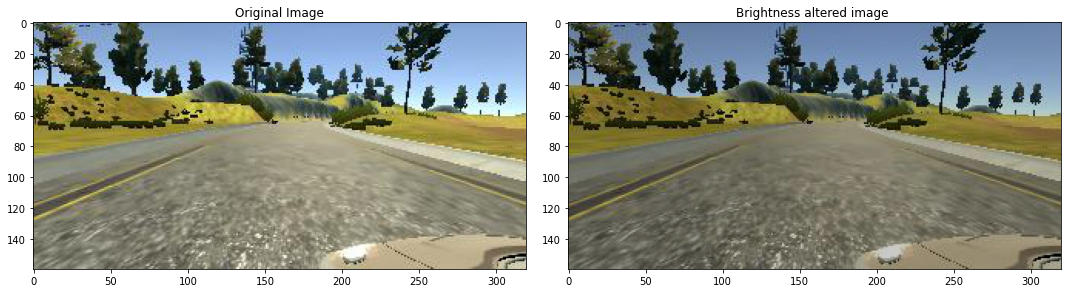

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [30]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [31]:
random_index = random.randint(0, 1000)
image = im[random_index]
steering_angle = st[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.19780862999999999')

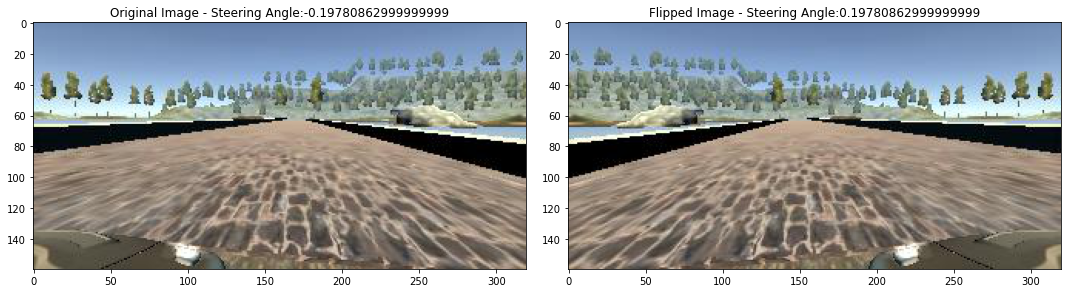

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [33]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

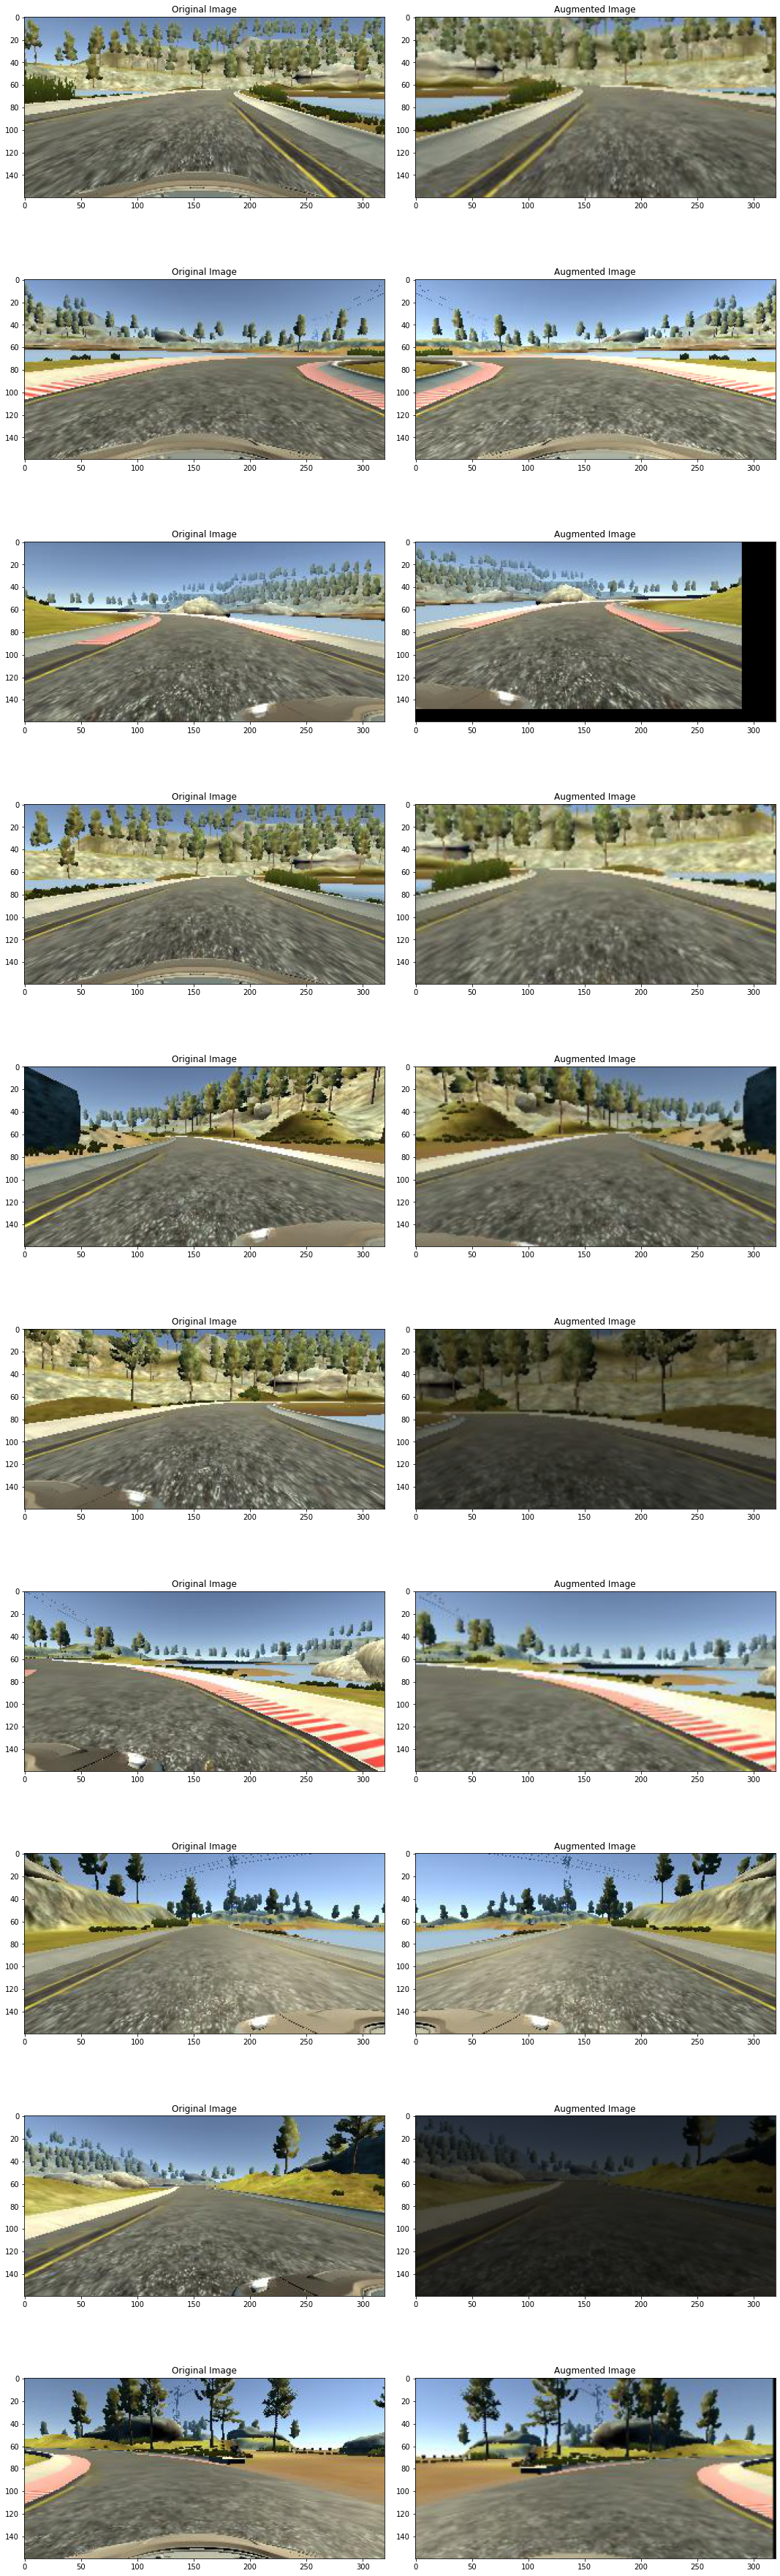

In [34]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(im) - 1)
  random_image = im[randnum]
  random_steering = st[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

## Batch Generator

In [35]:
def batch_generator(image_paths, steering_angles,batch_size,istraining):
  while True:
    batch_img=[]
    batch_steer=[]
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        image, steering = random_augment(image_paths[random_index], steering_angles[random_index])
      else:
        image=mpimg.imread(image_paths[random_index])
        steering=steering_angles[random_index]

      image=preprocess(image)
      batch_img.append(image)
      batch_steer.append(steering)

    yield np.asarray(batch_img),np.asarray(batch_steer)
  

  ###  Incorporate Data Augmentation

  For example if I take a batch of 1 I have

In [36]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1,1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1,0))

Text(0.5, 1.0, 'Validation Image')

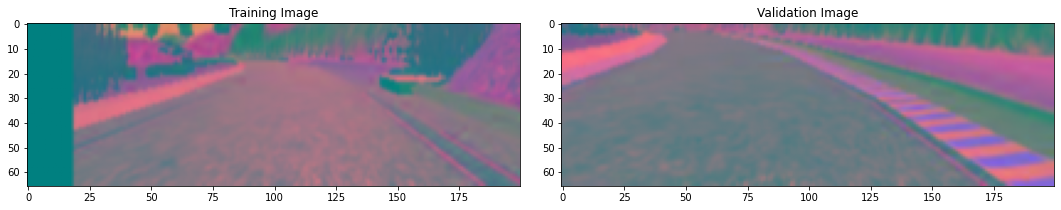

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

## The Model

I am going to implement NVIDIA model depicted in [End-to-End Deep Learning for Self-Driving Cars](https://developer.nvidia.com/blog/deep-learning-self-driving-cars/)

First let's check the input to verify it is in accordance to the shape of the Nvidia Model (66,200,3):

In [38]:
print("The shape of an input image is: ",x_train_gen[0].shape)

The shape of an input image is:  (66, 200, 3)


In [39]:
def nvidia_model():
  model=Sequential()

  #model.add(Lambda(preprocess, input_shape=(160,320,3)))

  model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2),activation="elu"))
  model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2),activation="elu"))

  model.add(Conv2D(64,kernel_size=(3,3),activation="elu"))
  model.add(Conv2D(64,kernel_size=(3,3),activation="elu"))
  #Dropout possible
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  #Dropout possible
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  #Dropout possible
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  #Dropout possible

  model.add(Dense(1))

  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model
 
 

In [40]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

To train the model I use fit_generator

In [41]:
batch_size=100
epochs=30

In [42]:
history = model.fit(batch_generator(X_train, y_train, batch_size, 1),
                                  steps_per_epoch=300, 
                                  epochs=epochs,
                                  validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                                  validation_steps=200,
                                  verbose = 1,
                                  shuffle = 1)

Epoch 1/30
300/300 [==============================] - 183s 609ms/step - loss: 0.1011 - val_loss: 0.0469
Epoch 2/30
300/300 [==============================] - 183s 610ms/step - loss: 0.0584 - val_loss: 0.0406
Epoch 3/30
300/300 [==============================] - 183s 610ms/step - loss: 0.0559 - val_loss: 0.0391
Epoch 4/30
300/300 [==============================] - 184s 613ms/step - loss: 0.0534 - val_loss: 0.0373
Epoch 5/30
300/300 [==============================] - 183s 609ms/step - loss: 0.0510 - val_loss: 0.0357
Epoch 6/30
300/300 [==============================] - 184s 612ms/step - loss: 0.0497 - val_loss: 0.0335
Epoch 7/30
300/300 [==============================] - 185s 615ms/step - loss: 0.0470 - val_loss: 0.0325
Epoch 8/30
300/300 [==============================] - 184s 613ms/step - loss: 0.0458 - val_loss: 0.0322
Epoch 9/30
300/300 [==============================] - 184s 614ms/step - loss: 0.0441 - val_loss: 0.0303
Epoch 10/30
300/300 [==============================] - 185s 615m

In [43]:
# Model.fit_generator is deprecated and will be removed in future versions.
# Model.fit supports generators
#history = model.fit_generator(batch_generator(X_train, y_train, batch_size, 1),
#                                  steps_per_epoch=300, 
#                                  epochs=epochs,
#                                  validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
#                                  validation_steps=200,
#                                  verbose = 1,
#                                  shuffle = 1)

In [44]:
#l=[0.0466,0.0191,0.0168,0.0123,0.0144,0.0134,0.0129,0.0121,0.0110,0.0102]
#v=[0.0226,0.0203,0.0199,0.0181,0.0159,0.0157,0.0151,0.0162,0.0149,0.0162]

In [45]:
#import matplotlib.pyplot as plt
#plt.plot(l)
#plt.plot(v)
#plt.title('model mean squared error loss')
#plt.ylabel('mean squared error loss')
#plt.xlabel('epoch')
#plt.ylim(0,0.25)
#plt.legend(['training set', 'validation set'], loc='upper right')
#plt.show()

Text(0.5, 0, 'Epoch')

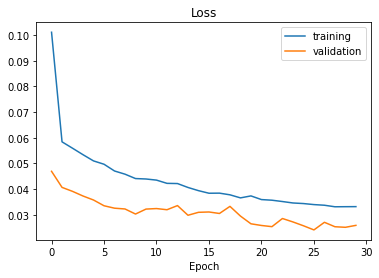

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [47]:
model.save('modelWITHDrop3.h5')

In [48]:
from google.colab import files
files.download('modelWITHDrop3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(not used from here)

In [49]:
#!python --version

In [50]:
#import tensorflow as tf
#print(tf.__version__)

In [51]:
#keras.__version__

In [52]:
#cv2.__version__

In [53]:
#np.__version__